In [10]:
import pandas as pd
import src.scrape_insta
import src.clean as clean
%autoreload
import numpy as np
import re 
from selenium import webdriver
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from IPython.display import HTML
from bs4 import BeautifulSoup
import json.decoder as decoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [112]:
qualdf = pd.read_csv('soft_content.txt', sep="|")

In [113]:
urls = list(qualdf.url.unique())
pickle_in2 = open("quant_data.pkl","rb")
quant_df = pickle.load(pickle_in2)

In [459]:
combined = clean.combine_data(qualdf,quant_df)
combined2 = clean.clean_combined(combined)

# Changing columns for clustering

In [372]:
combined2['female'] = (combined2['female'] | combined2['mixed_gender'])
combined2['male'] = (combined2['male'] | combined2['mixed_gender'])
combined2['bikini'] = (combined2['bikini'] | combined2['biki+apparel'])
combined2['apparel'] = (combined2['apparel'] | combined2['biki+apparel'])

drop_redundency = combined2.drop(['hour','month','mixed_gender', 
                                  'biki+apparel', 'no_product', 
                                  'num_people_tagged'], axis=1)

In [63]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(drop_redundency)
sil_scores=[]

In [84]:
i=20
kmeans = KMeans(n_clusters=i)
kmeans.fit(scaled)
clustered= kmeans.predict(scaled) 
sil = silhouette_score(scaled,clustered)
print (sil)
sil_scores.append((i,sil))
scores = [tup[1] for tup in sil_scores]

0.3012527560325276


In [339]:
scores = [tup[1] for tup in sil_scores]

In [55]:
len(scores)+2

20

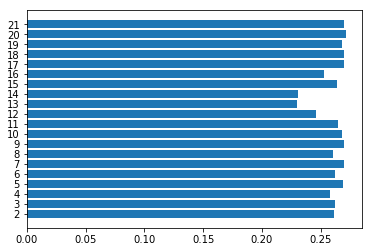

In [340]:
_=plt.barh(range(2, len(scores)+2),scores)
_=plt.yticks(range(2,len(scores)+2))

In [341]:
drop_redundency.columns

Index(['num_people', 'faces_visible', 'sale', 'edited', 'butt_pic', 'ocean',
       'skate', 'drift_content', 'product_shot', 'lifestyle', 'in_shop',
       'pro\model', 'in_nature', 'surf', 'male', 'female', 'bikini',
       'apparel'],
      dtype='object')

In [90]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(scaled)
clustered= kmeans.predict(scaled) 

In [106]:
(clustered).sum()

0

# with all data, Gradient Boosted Model

In [120]:
vocab, hashtag_tfidf = clean.make_hashtag_tfidf(combined)

In [121]:
combined3 = pd.concat([combined2, hashtag_tfidf], axis=1)

In [330]:
y = combined3['number_of_likes']
X = combined3.drop(['number_of_likes',], axis=1)


In [331]:
gbr = GradientBoostingRegressor(learning_rate=0.01, loss='ls',
                                min_samples_split=4, n_estimators=600,
                                max_depth=5)

In [332]:
scores = cross_val_score(gbr, X, y,cv=40, scoring= 'neg_mean_absolute_error')
print(scores.mean())
print(scores)

-47.44282499420545
[-49.35185244 -34.01859278 -55.30663012 -48.81983481 -63.54993564
 -78.43966903 -43.14274231 -58.90209852 -40.20633421 -34.15838779
 -58.88102472 -36.9006376  -41.94389842 -58.55579076 -66.5721752
 -39.6421669  -35.79778928 -27.28122575 -42.6981405  -30.78152323
 -32.35316888 -34.98867612 -29.38257038 -32.41474708 -39.17337994
 -42.52086187 -49.59265912 -64.93545129 -55.43278104 -54.47485005
 -26.41009197 -49.74949182 -43.78593284 -71.76794565 -40.57075596
 -71.37615402 -75.74838411 -31.03283764 -65.10674258 -41.94506742]


In [135]:
scores = cross_val_score(gbr, X, y,cv=40, scoring= 'neg_mean_absolute_error')
print(scores.mean())
print(scores)

-46.70920500777229
[-54.48138522 -31.81324439 -50.36633968 -52.68573809 -58.21127373
 -72.55953648 -37.0740229  -51.3888506  -43.79867118 -30.31943009
 -56.88270972 -45.80547014 -50.67626939 -56.56372853 -67.05357854
 -36.97257314 -30.94725663 -35.66019022 -43.80198209 -32.47095404
 -40.75282747 -36.54770504 -26.43894449 -35.08625148 -45.09246542
 -39.02489699 -49.68799814 -65.54683539 -63.26900041 -48.25248014
 -21.68331523 -45.50784708 -39.79483085 -61.46150434 -41.75406755
 -69.43898426 -67.93290031 -26.00337208 -62.17765514 -43.38111372]


In [140]:
max_depth =[(2,47.05287822339375),(3,46.70920500777229),(4,46.05935529376886),(5,47.39873085759742)]

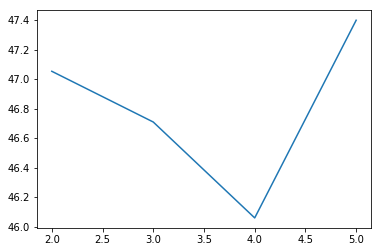

In [144]:
_=plt.plot([tup[0] for tup in max_depth],[tup[1] for tup in max_depth])

In [147]:
print(combined3['number_of_likes'].mean())
print(combined3['number_of_likes'].std())


276.02962962962965
74.50495263004379


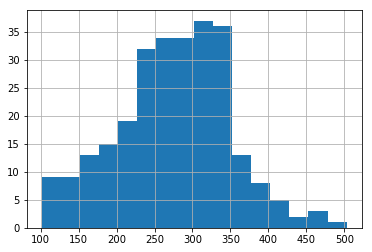

In [156]:
combined3['number_of_likes'].hist(bins=16)

In [166]:
X_train, X_test, y_train, y_test=train_test_split(X.as_matrix(), y.as_matrix(),test_size=.1)

In [169]:
gbr.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=600, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [171]:
feats=gbr.feature_importances_

In [188]:
for name, imp in zip(X.columns, feats):
    if imp > .01:
        if type(name) == int:
            name = '{}-{}'.format(name, rev_dict[name])

            print("{} : {}".format(name, round(imp,3)))

hour : 0.057
month : 0.107
num_people_tagged : 0.027
butt_pic : 0.018
pro\model : 0.02
no_product : 0.012
48-cheekybikini : 0.011
87-driftbikinis : 0.022
114-fempreneur : 0.011
134-grainisgood : 0.011
136-grassroots : 0.016
140-handmadebikini : 0.01
163-indiansummer : 0.014
208-minimalzine : 0.031
219-mytinyatlas : 0.019
225-northeastcollective : 0.015
227-nothingincommon : 0.021
236-oneofakind : 0.012
260-portraits_mf : 0.011
262-portsmouth : 0.016
263-portsmouthnh : 0.019
302-shoplocal : 0.016
366-thedriftcollective : 0.026
397-vintage : 0.015
402-vintagedenim : 0.013
403-vintagefashion : 0.015


In [296]:
only_appears_once = []
for tag in hashtag_occurances.keys():
    if hashtag_occurances[tag] == 1:
        only_appears_once.append(tag)

In [301]:
numbers_to_remove = []
for tag in only_appears_once:
    numbers_to_remove.append(vocab[tag.lower()])

In [325]:
numbers_to_remove

[244,
 240,
 115,
 355,
 28,
 360,
 321,
 350,
 352,
 413,
 295,
 398,
 395,
 311,
 71,
 313,
 392,
 393,
 268,
 197,
 315,
 284,
 290,
 235,
 168,
 167,
 275,
 209,
 23,
 196,
 177,
 351,
 384,
 16,
 56,
 210,
 382,
 427,
 332,
 10,
 410,
 408,
 330,
 280,
 283,
 409,
 211,
 65,
 102,
 308,
 50,
 145,
 19,
 133,
 334,
 318,
 387,
 99,
 285,
 165,
 47,
 258,
 25,
 192,
 286,
 193,
 312,
 333,
 394,
 124,
 35,
 57,
 41,
 375,
 80,
 319,
 108,
 42,
 220,
 37,
 89,
 234,
 72,
 146,
 399,
 53,
 54,
 302,
 34,
 340,
 81,
 149,
 7,
 379,
 249,
 101,
 178,
 5,
 155,
 305,
 297,
 217,
 74,
 43,
 224,
 373,
 238,
 335,
 254,
 2,
 253,
 162,
 239,
 267,
 269,
 251,
 11,
 76,
 195,
 181,
 6,
 154,
 119,
 61,
 20,
 316,
 12,
 383,
 299,
 21,
 376,
 270,
 293,
 354,
 153,
 73,
 296,
 88,
 150,
 199,
 363,
 250,
 75,
 407,
 248,
 105,
 106,
 189,
 24,
 343,
 78,
 31,
 107,
 164,
 227,
 60,
 310,
 327,
 347,
 121,
 256,
 125,
 137,
 255,
 153,
 127,
 128,
 271,
 272,
 287,
 86,
 328,
 144,
 109,
 95,

{'35analog': 0,
 '35mm': 1,
 '35mmfilm': 2,
 '603': 3,
 '90sfashion': 4,
 '90shiphop': 5,
 '90skids': 6,
 '90sparty': 7,
 'abikiniaday': 8,
 'accidentalzine': 9,
 'acidwash': 10,
 'acrylicpainting': 11,
 'acurrentaffair': 12,
 'analogue': 13,
 'analoguevibes': 14,
 'analogvibes': 15,
 'antiques': 16,
 'archivecollectivemag': 17,
 'artistcollaboration': 18,
 'asburypark': 19,
 'atelier': 20,
 'babetown': 21,
 'beach': 22,
 'beachwear': 23,
 'beastcoast': 24,
 'beckley': 25,
 'bestfitsdaily': 26,
 'betheadventure': 27,
 'biarritz': 28,
 'biggie': 29,
 'bikiniready': 30,
 'birthdaygirl': 31,
 'birthdayshots': 32,
 'bleachmyfilm': 33,
 'blockisland': 34,
 'boston': 35,
 'bostonblogger': 36,
 'bowie': 37,
 'broadmag': 38,
 'bubblerock': 39,
 'cactus': 40,
 'cali': 41,
 'camouflage': 42,
 'capecod': 43,
 'champagne': 44,
 'chasinglight': 45,
 'cheadsmagazine': 46,
 'cheeky': 47,
 'cheekybikini': 48,
 'cheers': 49,
 'chugandshop': 50,
 'coastallife': 51,
 'collaborationmastered': 52,
 'colora

In [228]:
imp_tags = [(48,'cheekybikini'), (87,'driftbikinis'), (114,'fempreneur' ), 
(134,'grainisgood'),(136,'grassroots'), (140,'handmadebikini'),
(163,'indiansummer'), (208,'minimalzine'), (219,'mytinyatlas'),
(225,'northeastcollective'),(227,'nothingincommon'),(236,'oneofakind'),
(260,'portraits_mf'),(262,'portsmouth' ), (263,'portsmouthnh'),
(302,'shoplocal'),(366,'thedriftcollective'),(397,'vintage'),
(402,'vintagedenim'),(403,'vintagefashion')]

In [235]:
likes_data={}
for num, tag in zip([tup[0] for tup in imp_tags],[tup[1] for tup in imp_tags]):
    likes_data[tag] = (hashtag_occurances[tag], combined3[combined3[num] >0].number_of_likes.mean(), combined3[combined3[num] >0].number_of_likes.std())

In [236]:
likes_data

{'cheekybikini': (8, 264.85714285714283, 66.81923019467916),
 'driftbikinis': (32, 297.65625, 94.88791669054056),
 'fempreneur': (12, 234.91666666666666, 83.17938810823632),
 'grainisgood': (135, 263.5777777777778, 70.5737115094488),
 'grassroots': (9, 310.3333333333333, 92.28488500290824),
 'handmadebikini': (10, 300.3, 33.07247932781709),
 'indiansummer': (2, 151.5, 60.10407640085654),
 'minimalzine': (180, 278.3820224719101, 74.19816277104415),
 'mytinyatlas': (43, 282.7906976744186, 64.87958008037987),
 'northeastcollective': (5, 166.2, 49.2767693746252),
 'nothingincommon': (31, 310.15625, 66.50399424094766),
 'oneofakind': (1, 202.0, nan),
 'portraits_mf': (12, 333.0, 73.63546576332507),
 'portsmouth': (14, 318.92857142857144, 65.60893968837605),
 'portsmouthnh': (68, 268.2238805970149, 67.24780516763586),
 'shoplocal': (49, 285.0204081632653, 67.99769904070234),
 'thedriftcollective': (131, 276.3484848484849, 73.22640670487776),
 'vintage': (10, 322.6, 65.62892316315693),
 'vint

In [176]:
rev_dict={}
for key, val in vocab.items():
    rev_dict[val]= key

In [183]:
hashtag_occurances = {}
for post in list(combined.hashtags):
    for tag in post:
        tag = re.sub('\#', '', tag) 
        if tag not in hashtag_occurances:
            hashtag_occurances[tag] = 1
        else: 
            hashtag_occurances[tag] += 1

In [227]:
print(combined3[combined3[140] >0].number_of_likes.mean())
print(combined3[combined3[140] >0].number_of_likes.std())

300.3
33.07247932781709


In [213]:
combined3[combined3[302] <= 0].number_of_likes.mean()

274.03619909502265

In [206]:
combined3.number_of_likes.mean()

276.02962962962965

244

In [241]:
likes_by_hour={}
for hour in combined3['hour'].unique():
    count = len(combined3[combined3['hour']== hour])
    mean = combined3[combined3['hour']== hour].number_of_likes.mean()
    std = combined3[combined3['hour']== hour].number_of_likes.std()
    likes_by_hour[hour] = (count,round(mean,2),round(std,2))

In [242]:
likes_by_hour

{0: (16, 318.62, 48.05),
 1: (21, 313.29, 62.53),
 2: (13, 311.38, 52.55),
 3: (13, 334.15, 73.42),
 4: (1, 402.0, nan),
 11: (1, 283.0, nan),
 12: (8, 310.5, 103.03),
 13: (8, 263.62, 76.26),
 14: (11, 249.27, 60.37),
 15: (39, 264.82, 68.4),
 16: (34, 239.06, 83.53),
 17: (28, 242.57, 84.65),
 18: (24, 251.71, 81.3),
 19: (17, 291.12, 52.42),
 20: (8, 256.75, 45.96),
 21: (11, 286.82, 47.87),
 22: (8, 286.62, 50.41),
 23: (9, 299.89, 42.19)}

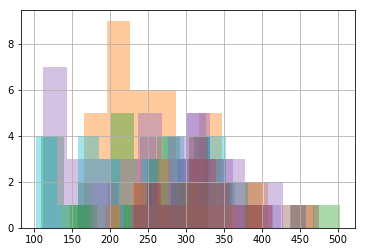

In [252]:
for hour in combined3['hour'].unique():
    combined3[combined3['hour']== hour].number_of_likes.hist(alpha=.4)

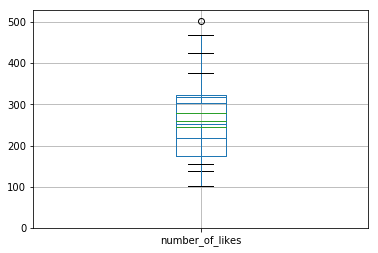

In [261]:
combined3[combined3['hour']< 4].number_of_likes.hist(alpha=.4)
combined3[(combined3['hour']> 10)&(combined3['hour']<16)].boxplot(column='number_of_likes')
combined3[(combined3['hour']> 15)&(combined3['hour']<19)].boxplot(column='number_of_likes')
combined3[(combined3['hour']> 18)&(combined3['hour']<24)].boxplot(column='number_of_likes')

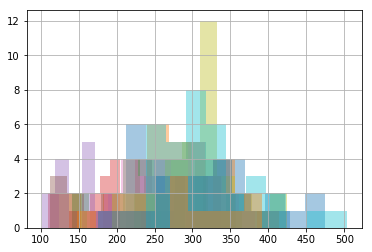

In [262]:
for month in combined3['month'].unique():
    combined3[combined3['month']== month].number_of_likes.hist(alpha=.4)

In [265]:
print(combined3[combined3['butt_pic']==True].number_of_likes.mean())
print(combined3[combined3['butt_pic']==True].number_of_likes.std())

317.41379310344826
73.47668106344028


In [266]:
print(combined3[combined3['pro\\model']==True].number_of_likes.mean())
print(combined3[combined3['pro\\model']==True].number_of_likes.std())

298.3783783783784
81.29280115434281


In [306]:
import src.instagram_profile_scraper as in_scrape
%autoreload

In [307]:
browser = in_scrape.login_insta('kait.stearns','Wilmot11')

In [308]:
info = in_scrape.scrape_profile_info(browser, 'fess_matt_')

In [334]:
info;

In [315]:
matt = pd.DataFrame.from_dict(info, orient='index')

In [318]:
matt = matt.transpose()

In [319]:
pickle_out = open("matt.pkl","wb")
pickle.dump(matt, pickle_out)
pickle_out.close()

In [320]:
pickle_in = open("matt.pkl","rb")
matt2 = pickle.load(pickle_in)


In [418]:
product_shots = drop_redundency[(drop_redundency['product_shot'] == 1)]
without_dow = product_shots.drop(['sale','male','female','DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 
                      'DOW_5', 'DOW_6','number_of_likes'], axis = 1)

127

In [419]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(without_dow)

In [420]:
sil_scores =[]
for i in range(2,20):
    km = KMeans(n_clusters=i)
    km.fit(scaled)
    clustered= km.predict(scaled) 
    sil = silhouette_score(scaled,clustered)
    sil_scores.append((i,sil))
    scores = [tup[1] for tup in sil_scores]

In [382]:
sil_scores;

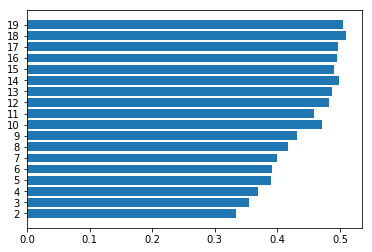

In [421]:
_=plt.barh(range(2, len(scores)+2),scores)
_=plt.yticks(range(2,len(scores)+2))

In [422]:
km = KMeans(n_clusters=5)
km.fit(scaled)
clustered= km.predict(scaled) 

In [423]:
len(clustered)

127

In [426]:
product_shots['clusters']= clustered

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [427]:
for i in range(5):
    print('For cluster {}:'.format(i))
    print('groupsize: {}'.format(len(product_shots[product_shots['clusters']==i])))
    print('mean: {}'.format(product_shots[product_shots['clusters']==i].number_of_likes.mean()))
    print('std: {}'.format(product_shots[product_shots['clusters']==i].number_of_likes.std()))

For cluster 0:
groupsize: 36
mean: 282.27777777777777
std: 77.70847025393273
For cluster 1:
groupsize: 15
mean: 296.6
std: 82.52514768238831
For cluster 2:
groupsize: 16
mean: 306.4375
std: 81.95280654132597
For cluster 3:
groupsize: 57
mean: 266.64912280701753
std: 66.77453835430894
For cluster 4:
groupsize: 3
mean: 179.66666666666666
std: 21.1266025033211


In [428]:
c1 = list(product_shots[product_shots['clusters']==0].number_of_likes)
c2 =list(product_shots[product_shots['clusters']==1].number_of_likes)
c3=list(product_shots[product_shots['clusters']==2].number_of_likes)
c4=list(product_shots[product_shots['clusters']==3].number_of_likes)
c5=list(product_shots[product_shots['clusters']==4].number_of_likes)

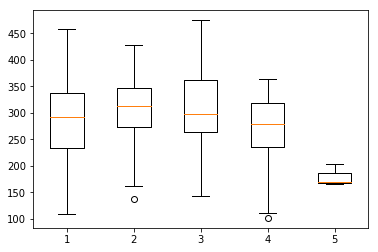

In [430]:
_=plt.boxplot([c1,c2,c3,c4, c5])

In [417]:
off_ppl_product_shot = product_shots[product_shots['clusters']==2]

In [457]:
print()
for name, val1,val2,val3,val4,val5 in zip(without_dow.columns,km.cluster_centers_[0],km.cluster_centers_[1],km.cluster_centers_[2],km.cluster_centers_[3],km.cluster_centers_[4]):
    print("{}: {} | {} | {} | {} | {}".format(name, round(val1,2), round(val2,2), round(val3,2), round(val4,2), round(val5,2)))


num_people: 0.68 | 0.45 | 0.53 | -0.82 | 2.33
faces_visible: 1.21 | -0.45 | -0.46 | -0.57 | 0.9
edited: 0.04 | -0.22 | 0.37 | -0.06 | -0.22
butt_pic: -0.39 | 0.59 | 1.81 | -0.39 | -0.39
ocean: -0.3 | 2.43 | -0.19 | -0.38 | -0.38
skate: -0.16 | -0.16 | -0.16 | -0.16 | 6.43
drift_content: -0.76 | -0.64 | -0.79 | 0.93 | -1.04
product_shot: 0.0 | 0.0 | 0.0 | 0.0 | 0.0
lifestyle: 0.48 | 1.01 | 0.51 | -0.74 | 0.6
in_shop: -0.44 | -0.99 | -0.74 | 0.8 | -0.99
pro\model: 0.51 | -0.23 | 1.09 | -0.54 | -0.54
in_nature: -0.11 | 1.95 | 0.18 | -0.47 | -0.47
surf: 0.14 | 0.58 | -0.18 | -0.18 | -0.18
bikini: 0.29 | 0.59 | 1.13 | -0.61 | -0.89
apparel: -0.1 | -0.61 | -1.05 | 0.48 | 0.77


In [458]:
combined3.columns

Index([            'DOW_0',             'DOW_1',             'DOW_2',
                   'DOW_3',             'DOW_4',             'DOW_5',
                   'DOW_6',              'hour',             'month',
       'num_people_tagged',
       ...
                       418,                 419,                 420,
                       421,                 422,                 423,
                       424,                 425,                 426,
                       427],
      dtype='object', length=460)

# answering questions

In [471]:
bikinis = combined2[(combined2['bikini']== True)|(combined2['biki+apparel']== True)]
apparel = combined2[(combined2['apparel']== True)|(combined2['biki+apparel']== True)]
bikini_app_comb = combined2[combined2['biki+apparel']== True]


In [466]:
print(bikinis.number_of_likes.mean())
print(bikinis.number_of_likes.std())
print(len(bikinis))

293.5
74.56696037084635
96


In [467]:
print(apparel.number_of_likes.mean())
print(apparel.number_of_likes.std())
print(len(apparel))

270.25333333333333
71.23825104277273
150


## it appears apparel pictures on average perform slightly worse that bikini pictures

In [468]:
butt_pics = bikinis[bikinis['butt_pic']==True]
bikinis_no_butts = bikinis[bikinis['butt_pic']==False]

In [469]:
print(butt_pics.number_of_likes.mean())
print(butt_pics.number_of_likes.std())
print(len(butt_pics))

317.41379310344826
73.47668106344028
29


In [470]:
print(bikinis_no_butts.number_of_likes.mean())
print(bikinis_no_butts.number_of_likes.std())
print(len(bikinis_no_butts))

283.14925373134326
73.16363017058185
67


## further, bikini pics with butts perform better than bikini pics w/o butts. however bother still perfom bettter than the general apparel pics

In [472]:
print(bikini_app_comb.number_of_likes.mean())
print(bikini_app_comb.number_of_likes.std())
print(len(bikini_app_comb))

273.2142857142857
100.48817655014756
14


In [474]:
bikini_no_ppl= bikinis[bikinis['num_people']==0]
apparel_no_ppl= apparel[apparel['num_people']==0]

In [475]:
print(bikini_no_ppl.number_of_likes.mean())
print(bikini_no_ppl.number_of_likes.std())
print(len(bikini_no_ppl))

308.1111111111111
36.937259117469864
9


In [476]:
print(apparel_no_ppl.number_of_likes.mean())
print(apparel_no_ppl.number_of_likes.std())
print(len(apparel_no_ppl))

260.8627450980392
64.22025213523945
51


In [488]:
print(apparel_no_ppl[apparel_no_ppl['female']==1].number_of_likes.mean())
print(apparel_no_ppl[apparel_no_ppl['female']==1].number_of_likes.std())
print(len(apparel_no_ppl[apparel_no_ppl['female']==1]))

print()
print(apparel_no_ppl[apparel_no_ppl['mixed_gender']==1].number_of_likes.mean())
print(apparel_no_ppl[apparel_no_ppl['mixed_gender']==1].number_of_likes.std())
print(len(apparel_no_ppl[apparel_no_ppl['mixed_gender']==1]))

print()
print(apparel_no_ppl[apparel_no_ppl['male']==1].number_of_likes.mean())
print(apparel_no_ppl[apparel_no_ppl['male']==1].number_of_likes.std())
print(len(apparel_no_ppl[apparel_no_ppl['male']==1]))


255.1875
74.75668866395836
16

255.63636363636363
69.08279742767297
22

276.6923076923077
38.50191470430316
13


# However, pictures without people with male content does better than female or mixed gender

In [493]:
print(bikinis[bikinis['lifestyle']==1].number_of_likes.mean())
print(bikinis[bikinis['lifestyle']==0].number_of_likes.mean())
print(len(bikinis[bikinis['lifestyle']==1]))
print(len(bikinis[bikinis['lifestyle']==0]))

305.5
267.1
66
30


In [497]:
print(apparel[apparel['lifestyle']==1].number_of_likes.mean())
print(apparel[apparel['lifestyle']==0].number_of_likes.mean())
print(len(apparel[apparel['lifestyle']==1]))
print(len(apparel[apparel['lifestyle']==0]))

278.075
261.3142857142857
80
70


# lifestyle shots are more successful for both apparel and bikinis, especially big difference for bikinis

In [498]:
modelly = combined2[combined2['pro\\model']== True]
not_modelly = combined2[combined2['pro\\model']== False]

In [508]:
print(modelly.number_of_likes.mean())
print(modelly.number_of_likes.std())
print(len(modelly))
print()
print(not_modelly.number_of_likes.mean())
print(not_modelly.number_of_likes.std())
print(len(not_modelly))

298.3783783783784
81.29280115434281
37

272.48068669527896
72.92811065470124
233


In [507]:
print(modelly[modelly['bikini']==True].number_of_likes.mean())
print(modelly[modelly['apparel']==True].number_of_likes.mean())
print(modelly[modelly['biki+apparel']==True].number_of_likes.mean())
print(len(modelly[modelly['bikini']==True]))
print(len(modelly[modelly['apparel']==True]))
print(len(modelly[modelly['biki+apparel']==True]))


291.5
398.0
267.0
26
4
7


In [513]:
print(not_modelly[not_modelly['bikini']==True].number_of_likes.mean())
print(not_modelly[not_modelly['bikini']==True].number_of_likes.std())
print(len(modelly[modelly['bikini']==True]))


299.5
67.02943722384558
26


In [516]:
combined2[combined2['apparel']==True].number_of_likes.mean()

269.9485294117647

# modelly pictures perform better than the general population, however not modelly bikini pics slightly outperforn modelly ones (real girls win!)
1. moddely apparel shots outperform non modelly apparel shots, but limited data
2. change for experiment here 

In [528]:
print('In General')
print(combined2[combined2['faces_visible']==True].number_of_likes.mean())
print(combined2[(combined2['faces_visible']==False)&(combined2['num_people']>0)].number_of_likes.mean())
print()
print('Bikinis')
print(bikinis[bikinis['faces_visible']==True].number_of_likes.mean())
print(bikinis[(bikinis['faces_visible']==False)&(bikinis['num_people']>0)].number_of_likes.mean())
print()
print('Apparel')
print(apparel[apparel['faces_visible']==True].number_of_likes.mean())
print(apparel[(apparel['faces_visible']==False)&(apparel['num_people']>0) ].number_of_likes.mean())
print()
print('Modelly')
print(modelly[modelly['faces_visible']==True].number_of_likes.mean())
print(modelly[(modelly['faces_visible']==False)&(modelly['num_people']>0) ].number_of_likes.mean())
print(len(modelly[(modelly['faces_visible']==False)&(modelly['num_people']>0) ]))

In General
283.9605263157895
278.3658536585366

Bikinis
297.1470588235294
287.85185185185185

Apparel
280.3170731707317
271.3965517241379

Modelly
298.2631578947368
298.5
18


###  Having faces visible is better across virtually all categories INCLUDING bikinis where its v hard to have visible faces and butt pictures

In [545]:
print('In General')

print(combined2[(combined2['in_nature']==True )&(combined2['num_people']>0)].number_of_likes.mean())
print(combined2[(combined2['in_nature']==False)&(combined2['num_people']>0)].number_of_likes.mean())
print()
print('Bikinis')
print(bikinis[(bikinis['in_nature']==True)&(bikinis['num_people']>0)].number_of_likes.mean())
print(bikinis[(bikinis['in_nature']==False)&(bikinis['num_people']>0)].number_of_likes.mean())
print(bikinis[(bikinis['in_nature']==False)&(bikinis['num_people']>0)&(bikinis['in_shop']==True)].number_of_likes.mean())
print(bikinis[(bikinis['in_nature']==False)&(bikinis['num_people']>0)&(bikinis['in_shop']==False)].number_of_likes.mean())

print()
print('Apparel')
print(apparel[(apparel['in_nature']==True)&(apparel['num_people']>0) ].number_of_likes.mean())
print(apparel[(apparel['in_nature']==False)&(apparel['num_people']>0) ].number_of_likes.mean())
print()
print('Modelly')
print(modelly[(modelly['in_nature']==True)&(modelly['num_people']>0)].number_of_likes.mean())
print(len(modelly[(modelly['in_nature']==True)&(modelly['num_people']>0)]))
print(modelly[(modelly['in_nature']==False)&(modelly['num_people']>0) ].number_of_likes.mean())


In General
301.2352941176471
269.9384615384615

Bikinis
307.5217391304348
274.5609756097561
282.1818181818182
271.76666666666665

Apparel
305.36842105263156
267.9

Modelly
303.4
10
296.51851851851853


In [574]:
biki_in_nat_w_ppl = bikinis[(bikinis['in_nature']==True )&(bikinis['num_people']>0)].number_of_likes
biki_in_shop_w_ppl = bikinis[(bikinis['in_nature']==False )&(bikinis['num_people']>0)&(bikinis['in_shop']==True)].number_of_likes
biki_no_nat_or_shop_w_ppl = bikinis[(bikinis['in_nature']==False )&(bikinis['num_people']>0)&(bikinis['in_shop']==False)].number_of_likes

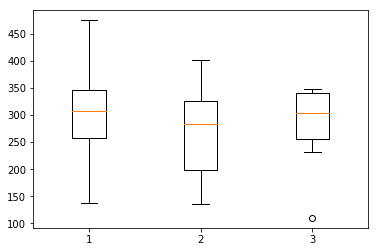

In [576]:
_=plt.boxplot([biki_in_nat_w_ppl, biki_no_nat_or_shop_w_ppl, biki_in_shop_w_ppl])

In [572]:
in_nat_w_ppl = list(combined2[(combined2['in_nature']==True )&(combined2['num_people']>0)].number_of_likes)
no_nat_w_ppl = combined2[(combined2['in_nature']==False )&(combined2['num_people']>0)].number_of_likes

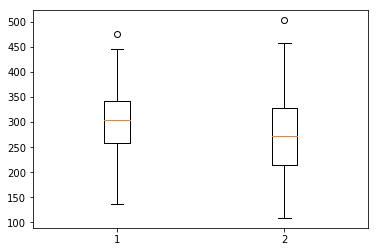

In [573]:
_=plt.boxplot([in_nat_w_ppl, no_nat_w_ppl])

In [571]:
in_nat_w_ppl

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,hour,month,num_people_tagged,...,pro\model,in_nature,surf,male,female,mixed_gender,bikini,apparel,biki+apparel,no_product
url,,,,,,,,,,,,,,,,,,,,,
http://www.instagram.com/p/BeN1t2onLY4/?taken,0,0,0,0,0,0,1,15,1,5,...,0,1,1,True,False,False,False,True,False,False
http://www.instagram.com/p/BeBk2rdnTo_/?taken,0,1,0,0,0,0,0,20,1,4,...,0,1,0,False,True,False,True,False,False,False
http://www.instagram.com/p/Bc7ngZ3n1eM/?taken,0,0,1,0,0,0,0,16,12,1,...,0,1,1,True,False,False,False,True,False,False
http://www.instagram.com/p/BckSPMDlWGN/?taken,1,0,0,0,0,0,0,15,12,6,...,0,1,1,True,False,False,False,False,False,True
http://www.instagram.com/p/Bbz55LuFRjZ/?taken,0,0,1,0,0,0,0,20,11,6,...,1,1,0,False,True,False,True,False,False,False
http://www.instagram.com/p/BZyof0rFuzY/?taken,0,1,0,0,0,0,0,15,10,2,...,0,1,0,False,True,False,True,False,False,False
http://www.instagram.com/p/BZpKFJNl7x8/?taken,0,0,0,0,1,0,0,23,9,3,...,1,1,0,False,True,False,True,False,False,False
http://www.instagram.com/p/BZblCUzFKhc/?taken,0,0,0,0,0,0,1,16,9,6,...,0,1,0,False,True,False,False,False,True,False
http://www.instagram.com/p/BZEeBuLFkb_/?taken,0,0,0,0,1,0,0,17,9,3,...,0,1,0,False,True,False,False,True,False,False


# pictures in nature CONSISTENTLY perform better as well 

In [542]:
print(combined2[combined2['num_people']==0].number_of_likes.mean())
print(combined2[combined2['num_people']>0].number_of_likes.mean())
print()
print('Bikinis')
print(bikinis[(bikinis['num_people']==0)].number_of_likes.mean())
print(len(bikinis[(bikinis['num_people']==0)]))
print(bikinis[(bikinis['num_people']>0)].number_of_likes.mean())
print(len(bikinis[(bikinis['num_people']>0)]))

print()
print('Apparel')
print(apparel[(apparel['num_people']==0)].number_of_likes.mean())
print(apparel[(apparel['num_people']>0)].number_of_likes.mean())
print()
print('Modelly')
print(modelly[(modelly['num_people']==0)].number_of_likes.mean())
print(len(modelly[modelly['num_people']==0]))
print(modelly[(modelly['num_people']>0) ].number_of_likes.mean())


263.22222222222223
280.6868686868687

Bikinis
308.1111111111111
9
291.98850574712645
87

Apparel
260.8627450980392
275.09090909090907

Modelly
nan
0
298.3783783783784


In [566]:
biki_no_ppl =list(bikinis[(bikinis['num_people']==0)].number_of_likes)
biki_ppl = list(bikinis[(bikinis['num_people']>0)].number_of_likes)

apar_no_ppl = list(apparel[(apparel['num_people']==0)].number_of_likes)
apar_ppl =list(apparel[(apparel['num_people']>0)].number_of_likes)

no_ppl = list(combined2[combined2['num_people']==0].number_of_likes)
ppl= list(combined2[combined2['num_people']>0].number_of_likes)


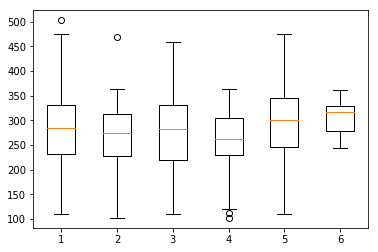

In [568]:
_=plt.boxplot([ppl, no_ppl,apar_ppl,apar_no_ppl, biki_ppl, biki_no_ppl])

# pictures with ppl in them perform better EXCEPT in with bikinis!! 
1. only 9 posts with bikinis and no ppl 
2. quite a bit higher average without ppl tho 

In [549]:
print('in general')
print(combined2[(combined2['num_people']>0)&(combined2['in_shop']==True)].number_of_likes.mean())
print(combined2[(combined2['num_people']>0)&(combined2['in_shop']==False)].number_of_likes.mean())
print(combined2[(combined2['num_people']==0)&(combined2['in_shop']==True)].number_of_likes.mean())
print(combined2[(combined2['num_people']==0)&(combined2['in_shop']==False)].number_of_likes.mean())
print('bikinis')
print(bikinis[(bikinis['num_people']>0)&(bikinis['in_shop']==True)].number_of_likes.mean())
print(bikinis[(bikinis['num_people']>0)&(bikinis['in_shop']==False)].number_of_likes.mean())
print(bikinis[(bikinis['num_people']==0)&(bikinis['in_shop']==True)].number_of_likes.mean())
print(bikinis[(bikinis['num_people']==0)&(bikinis['in_shop']==False)].number_of_likes.mean())
print('apparel')
print(apparel[(apparel['num_people']>0)&(apparel['in_shop']==True)].number_of_likes.mean())
print(apparel[(apparel['num_people']>0)&(apparel['in_shop']==False)].number_of_likes.mean())
print(apparel[(apparel['num_people']>0)&(apparel['in_shop']==False)&(apparel['in_nature']==False)].number_of_likes.mean())
print(apparel[(apparel['num_people']==0)&(apparel['in_shop']==True)].number_of_likes.mean())
print(apparel[(apparel['num_people']==0)&(apparel['in_shop']==False)].number_of_likes.mean())

in general
283.96774193548384
280.07784431137725
270.72727272727275
238.94117647058823
bikinis
282.1818181818182
293.4078947368421
316.14285714285717
280.0
apparel
279.95652173913044
273.61842105263156
263.03508771929825
264.72340425531917
215.5


# Other than for bikini posts with ppl in them, in shop pictures preform better than out of shop pics

In [553]:
prod_shot = combined2[combined2['product_shot']==True]

In [556]:
print(prod_shot.number_of_likes.mean())
print('more than one person')

print(prod_shot[prod_shot['num_people']>1].number_of_likes.mean())
print(prod_shot[prod_shot['num_people']>1].number_of_likes.std())
print('one person')

print(prod_shot[prod_shot['num_people']==1].number_of_likes.mean())
print(prod_shot[prod_shot['num_people']==1].number_of_likes.std())
print('no people')
print(prod_shot[prod_shot['num_people']==0].number_of_likes.mean())
print(prod_shot[prod_shot['num_people']==0].number_of_likes.std())

277.5748031496063
more than one person
263.42857142857144
46.33162038628746
one person
285.6666666666667
83.40733968737696
no people
268.5686274509804
65.90121543703447


In [557]:
none = list(prod_shot[prod_shot['num_people']==0].number_of_likes)
one = list(prod_shot[prod_shot['num_people']==1].number_of_likes)
more = list(prod_shot[prod_shot['num_people']>1].number_of_likes)

In [562]:
none_biki = list(prod_shot[(prod_shot['num_people']==0)&(prod_shot['bikini']==True)].number_of_likes)
one_biki = list(prod_shot[(prod_shot['num_people']==1)&(prod_shot['bikini']==True)].number_of_likes)
more_biki = list(prod_shot[(prod_shot['num_people']>1)&(prod_shot['bikini']==True)].number_of_likes)

product shots with one person are most successful

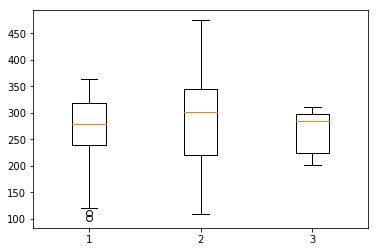

In [561]:
_=plt.boxplot([none, one, more])

#### the below plot suggests that there isnt enough data to conclude that bikini pics w/o ppl are more successful that w/ ppl

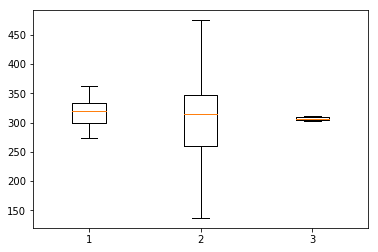

In [563]:
_=plt.boxplot([none_biki, one_biki, more_biki])

In [564]:
none_apar = list(prod_shot[(prod_shot['num_people']==0)&(prod_shot['apparel']==True)].number_of_likes)
one_apar = list(prod_shot[(prod_shot['num_people']==1)&(prod_shot['apparel']==True)].number_of_likes)
more_apar = list(prod_shot[(prod_shot['num_people']>1)&(prod_shot['apparel']==True)].number_of_likes)

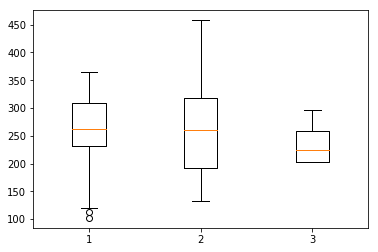

In [565]:
_=plt.boxplot([none_apar, one_apar, more_apar])